# **Calculated Features**
Real datasets often have underlying complex business rules. YData's platform allows a seamless combination of manually defined business rules with powerful synthesis technologies via a feature called **Calculated Features**, improving the quality of the generated datasets.

## Outline
* What are **Calculated Features**?
* An example dataset: loans
* Exploring the dataset
* Synthesizing data with and without **Calculated Features**
* Evaluating the synthetic data

## What are **Calculated Features**?
Features that are based on business rules and typically have a deterministic nature, through a combination of pre-existing features.

These calculated features, regardless of complexity, can be directly synthesized. However, the quality of the synthetic features can be improved if we infuse our models with some of the business logic we know right from the start.  

In this notebook, we will exemplify how business rules for feature calculation can be passed to YData's `RegularSynthesizer` and applied to the synthesis process as a way to improve fidelity.

## An example dataset: loans
For this example we have chosen a loans dataset from *LendingClub* loans. The original file can be found [here](https://data.world/lpetrocelli/lendingclub-loan-data-2017-q-1).

Loans, as a heavily procedural financial instrument, have of course underlying business logic. We expect our dataset to reflect some of these, like for instance: calculation of revolving credit utilization rate, monthly installment values and total payments.

## Exploring the dataset
First, let's read the dataset using a Google Cloud Connector, inspect the data and check, if, as expected, the business logic we mentioned is verified.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ydata.connectors import GCSConnector
from ydata.synthesizers.regular import RegularSynthesizer
from ydata.metadata.metadata import Metadata
from ydata.metadata.column import Column
from ydata.utils.data_types import DataType, VariableType
from utils import viz_main, viz_side_by_side # a couple of visualization utilities

# Reading our data file from the GCS cloud
connector = GCSConnector(project_id='ydatasynthetic')
real_ds = connector.read_file("gs://ydata_testdata/tabular/loan_data/loan_samples.csv.zip", file_type='csv')

# Inspecting head of the dataset
real_ds._train.head().T

,0,1,2,3,4
installment,111.97,356.78,276.56,130.0,185.93
int_rate,0.0749,0.1499,0.1139,0.1049,0.0724
loan_amnt,3600,15000,8400,4000,6000
revol_bal,5658,53167,12831,4388,9571
revol_util,0.149,0.753,0.303,0.332,0.413
term,36m,60m,36m,36m,36m
total_pymnt,0.0,0.0,0.0,0.0,164.21
total_rec_int,0.0,0.0,0.0,0.0,14.48
total_rec_late_fee,0.0,0.0,0.0,0.0,0.0
total_rec_prncp,0.0,0.0,0.0,0.0,149.73


Before verifying the business logic, let's first detail it: 
* The expected revolving balance (product of revolving balance utilization rate by total credit limit) should match the actual revolving balance
* For any given record, the average payment components should add up to the total payment
* For any given record, the cumulative payments should add up to the expected payment

The following visualizations will help us us validate these assumptions. 

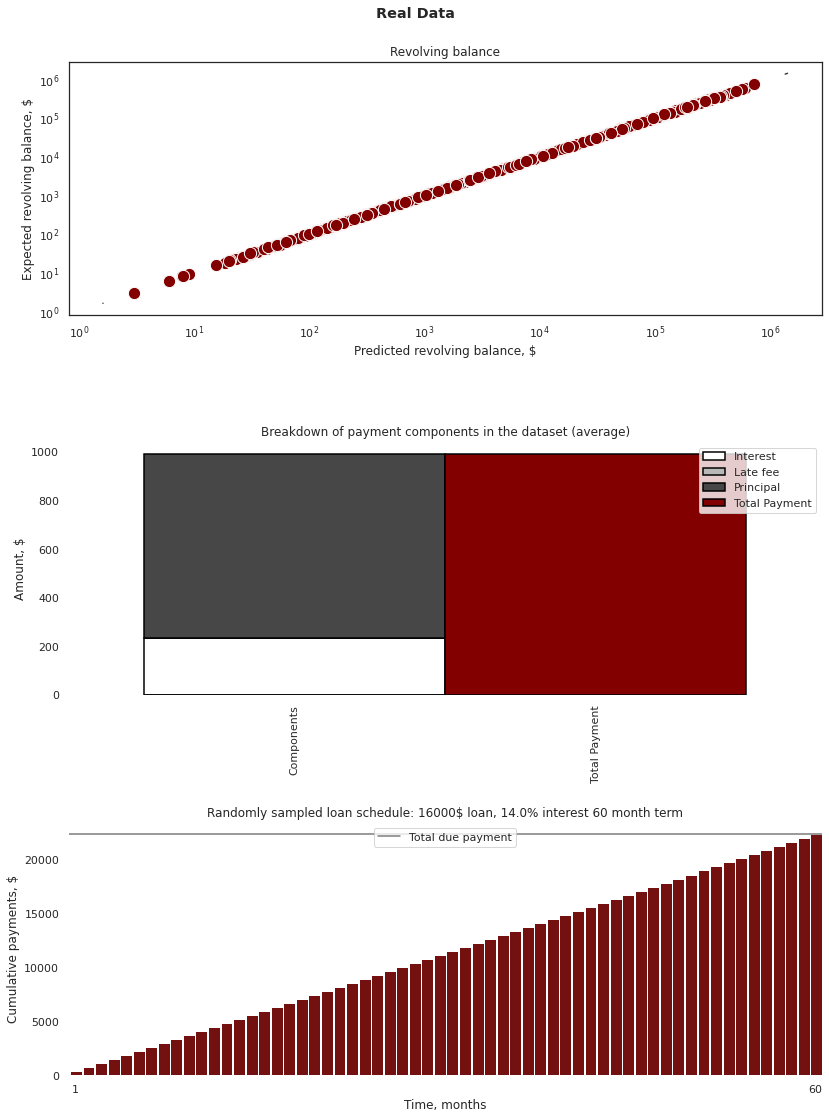

In [34]:
viz_main(real_ds)

The 3 aspects mentioned are indeed verified in the real data and any synthetic equivalent should exhibit these properties.

Let's check if we can leverage YData's `RegularSynthesizer`'s to achieve just that!

## Synthesizing data with and without **Calculated Features**

### Setting up

In [3]:
# Creating a metadata object
metadata = Metadata()
print(metadata(real_ds))

# Only term feature should be categorical
metadata.columns.update({c: Column(c, DataType.NUMERICAL, VariableType.FLOAT) for c in real_ds.columns if c != 'term'})

{'columns': {'installment': 'float', 'int_rate': 'float', 'loan_amnt': 'int', 'revol_bal': 'int', 'revol_util': 'float', 'term': 'string', 'total_pymnt': 'float', 'total_rec_int': 'float', 'total_rec_late_fee': 'float', 'total_rec_prncp': 'float', 'total_rev_hi_lim': 'int'}, 'target': None, 'shape': ((69521, 23097), 11), 'dataset_attr': None, 'warnings': {'skewness': ['revol_bal', 'total_pymnt', 'total_rec_int']}}


Everything regarding dataset metadata seems well specified, so we can proceed towards synthesis.

### Regular Synthesis 
Direct synthesis is obtained by passing the dataset and metadata objects to the `RegularSynthesizer`'s fit method.

In [ ]:
SAMPLE_SIZE = 1000
# Fit a synthesizer without using Calculated Features
synth_reg = RegularSynthesizer()
synth_reg.fit(real_ds, metadata=metadata)

# Obtaining samples
samples_reg = synth_reg.sample(SAMPLE_SIZE)

### Synthesis with **Calculated Features**
To produce the desired **Calculated Features** we will first translate each business rule into a function (either a regular method or a `lambda`) and infuse them into the `RegularSynthesizer`. 

Revolving credit utilization is computed as the quotient of revolving credit balance and the total limit of credit:

In [5]:
# Computes the revolving credit utilization based on the current revolving balance and the credit limit.
get_revolving_util = lambda revol_bal, total_rev_hi_lim : (revol_bal/total_rev_hi_lim).values

The installment (to be paid each month) is calculated according to the [formula for amortization](https://en.wikipedia.org/wiki/Amortization_calculator):

In [6]:
def get_installment(int_rate, loan_amnt, term):
    "Computes the installment values due monthly based on an amortization loan schedule."
    n = term.str.rstrip('m').astype('int')  # The total number of periods
    period_int = int_rate/12  # The adjusted annual interest for the monthly installment periods
    return loan_amnt*((period_int*(1+period_int)**n)/((1+period_int)**n-1)).values

The total payment is computed as the sum of all payment parcels:

In [7]:
def get_total_payment(total_rec_int, total_rec_late_fee, total_rec_prncp):
    "Computes total payment as the sum of all payment parcels."
    return (total_rec_int + total_rec_late_fee + total_rec_prncp).values

We can now train and sample from a synthesizer with this additional information:

In [8]:
calculated_features = [
    {
        'calculated_features': 'revol_util',
        'function': get_revolving_util,
        'calculated_from': ["revol_bal", "total_rev_hi_lim"]
    },
    {
        'calculated_features': 'installment',
        'function': get_installment,
        'calculated_from': ["int_rate", "loan_amnt", "term"]
    },
    {
        'calculated_features': 'total_pymnt',
        'function': get_total_payment,
        'calculated_from': ["total_rec_int", "total_rec_late_fee", "total_rec_prncp"]
    },
]

In [ ]:
# Fit a synthesizer using Calculated Features
synth_calcft = RegularSynthesizer()
synth_calcft.fit(real_ds, metadata=metadata, calculated_features=calculated_features)

# Obtaining samples
samples_calcft = synth_calcft.sample(SAMPLE_SIZE)

## Evaluating the synthetic data
Let's evaluate the effectiveness of our **Calculated Features** by redoing our EDA visualizations for both cases (with and without the manually defined business logic). 

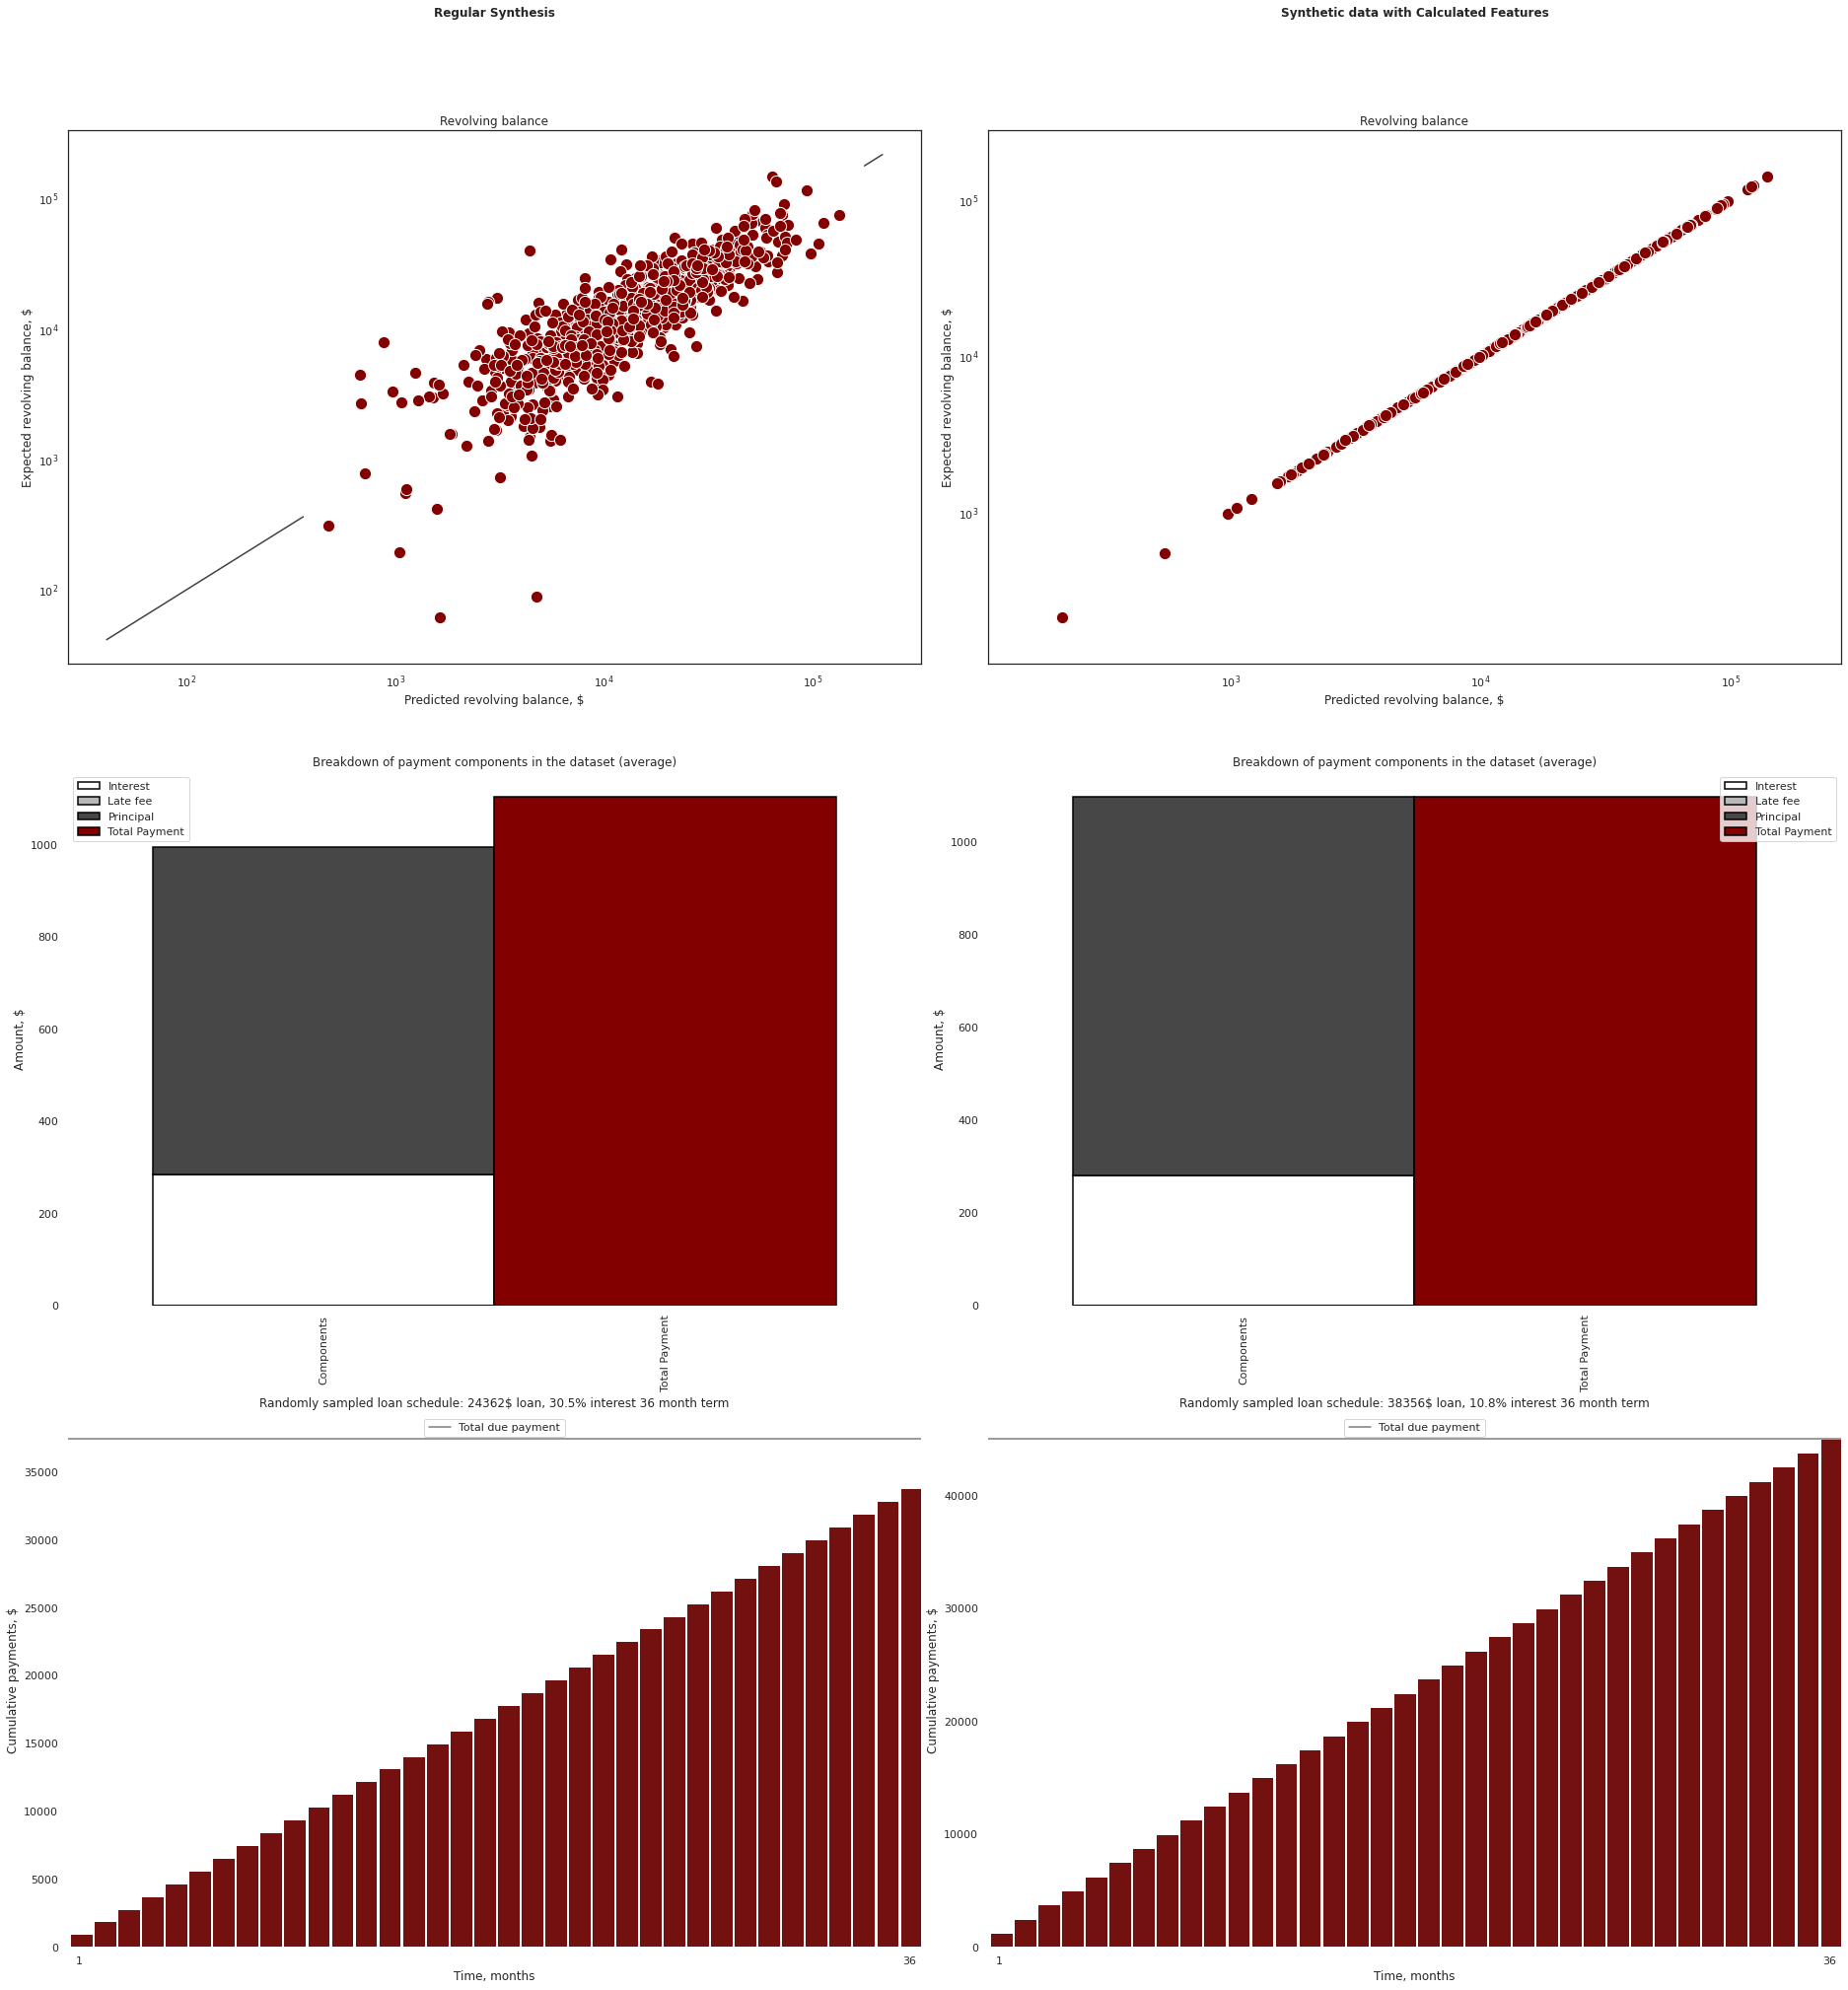

In [51]:
viz_side_by_side({'Regular Synthesis': samples_reg, 'Synthetic data with Calculated Features': samples_calcft})

The addition of the **Calculated Features** guarantees that the generated data tighthly adheres to our business constraints. Without it, instead of deterministic behaviours, we obtain close approximations. Combining data-driven modelling processes with domain knowledge guarantees we play to the strength's of each: learning the continuous distributions of the underlying features while maintaining the exact nature of business logic when they need to be combined.

### Wrapping up
As the synthetic data sample visualizations showed, by using **Calculated Features** we were able to verify the business rules found in the real data.

Defining **Calculated Features** is easy and allows us to guarantee that the produced samples respect intricate deterministic relationships. You can leverage this feature to make the synthetization models adhere to the specific constraints of your domain, simply by specifying them as functions. 